# MS 2.2- Group 10

**Members**: Niklas Grüner (12217059), Konstantin Unterweger (12222169), Martin Harhammer (12221683)


The following sections describe and implement an attempt to Audio Identification. 

## Imports

In [1]:
# imports
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
from IPython.display import clear_output
from collections import defaultdict

%matplotlib inline

## Utility functions

Here we define all functions that, we later need to compute spectrograms, constellation maps, the hashes and perform the matching

In [2]:
def load_filenames(directory):
    filenames = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        # Create the full path
        file_path = os.path.join(directory, filename)
        
        # Check if it is a file (not a directory)
        if os.path.isfile(file_path):
            # Add to the dictionary, using the filename as the key
            filenames.append(file_path)

    return filenames

In [3]:
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None, duration=None):
    x, Fs = librosa.load(fn_wav, sr=Fs, duration=30)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

In [4]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

In [5]:
from concurrent.futures import ThreadPoolExecutor

def compute_constellation_map_single(args):
    """Compute the constellation map for a single file."""
    filename, dist_freq, dist_time = args
    spectrogram = compute_spectrogram(filename)  # Perform I/O and computation
    constellation_map = compute_constellation_map(spectrogram, dist_freq, dist_time)
    return filename, constellation_map

def compute_constellation_maps(filenames, dist_freq, dist_time):
    """Compute constellation maps using multithreading."""
    # Prepare arguments for each file
    args = [(filename, dist_freq, dist_time) for filename in filenames]
    
    # Use ThreadPoolExecutor for multithreading
    with ThreadPoolExecutor() as executor:
        results = executor.map(compute_constellation_map_single, args)
    
    # Convert results to a dictionary
    Cmaps = dict(results)
    return Cmaps

In [6]:
def compute_hash(anchor, target):
    """Generate a 32-bit hash."""
    f1, t1 = anchor
    f2, t2 = target
    dt = t2 - t1
    return (f1 & 0x3FF) | ((f2 & 0x3FF) << 10) | ((dt & 0xFFF) << 20)



In [7]:
def get_target_zone_points(anchor, point_list,
                           time_min_offset, time_max_offset,
                           freq_min_offset, freq_max_offset):
    """
    Finds points in 'point_list' that lie within time [t1 + time_min_offset, t1 + time_max_offset]
    and frequency [f1 + freq_min_offset, f1 + freq_max_offset].
    
    anchor: (f1, t1) or (t1, f1) – whichever convention you are using.
    point_list: list of (f, t) or (t, f) – must be sorted by the time coordinate if we want to break early.
    time_min_offset, time_max_offset: how far in time we look relative to anchor's time t1.
    freq_min_offset, freq_max_offset: how far in frequency we look relative to anchor's freq f1.
    """
    f1, t1 = anchor
    
    # Time bounds
    t_min = t1 + time_min_offset
    t_max = t1 + time_max_offset
    
    # Frequency bounds
    f_min = f1 + freq_min_offset
    f_max = f1 + freq_max_offset
    
    target_zone_points = []
    for (f2, t2) in point_list:
        # If the list is sorted by time and t2 > t_max, we can break early.
        if t2 > t_max:
            break
        
        if t_min < t2 <= t_max and f_min <= f2 <= f_max:
            target_zone_points.append((f2, t2))
    
    return target_zone_points


In [8]:
import re
import random

def extract_numeric_id(filename):
    """
    Example: 
      - 'queries/1269810_original.mp3' => '1269810'
      - 'tracks/1269810.mp3'           => '1269810'
    Adjust to your naming conventions as needed.
    """
    match = re.search(r'(\d+)', filename)
    return match.group(1) if match else None

# Task 1

## Calculate constellation maps (with best configuration from MS2.1)

In [9]:
tracks = load_filenames('tracks') # load all track filenames
cmaps_D = compute_constellation_maps(tracks, 11, 3) # store the computed constellation maps for each configuration.


## Calculate hashes

In [10]:
import random
database = defaultdict(list)



# For each track, calculate hashes
for track_name, cmap in cmaps_D.items():
    # convert map to list, sort based on time
    point_list = sorted(np.argwhere(cmap).tolist(), key=lambda x: x[1])

    for anchor in point_list:
        target_points = get_target_zone_points(anchor, point_list, time_min_offset=5, time_max_offset=30, freq_min_offset=-15, freq_max_offset=15)

        for target_point in target_points:
            h = compute_hash(anchor, target_point)
            database[h].append((track_name, anchor[1])) # store trackname and time offset
 

if database:  # ensure dictionary is not empty
    key = random.choice(list(database.keys()))
    print("Random key:", key, "=> Value:", database[key])
else:
    print("Dictionary is empty")



Random key: 30512236 => Value: [('tracks/1414210.mp3', 353), ('tracks/1420410.mp3', 303)]


### Queries

In [11]:
queries = load_filenames('queries') # load all track filenames
cmaps_Q = compute_constellation_maps(queries, 11, 3) # store the computed constellation maps for each configuration.


MATCHING RESULTS:
Query: queries/1269810_original.mp3 => Best match: tracks/1269810.mp3, Offset: 128, Count: 523, Correct: True
Query: queries/1400510_noise.mp3 => Best match: tracks/768510.mp3, Offset: 317, Count: 5, Correct: False
Query: queries/887210_mobile.mp3 => Best match: tracks/887210.mp3, Offset: 90, Count: 51, Correct: True
Query: queries/1269810_noise.mp3 => Best match: tracks/1269810.mp3, Offset: 128, Count: 367, Correct: True
Query: queries/1400510_mobile.mp3 => Best match: tracks/296110.mp3, Offset: 97, Count: 8, Correct: False
Query: queries/1084710_mobile.mp3 => Best match: tracks/99810.mp3, Offset: 155, Count: 5, Correct: False
Query: queries/119410_original.mp3 => Best match: tracks/119410.mp3, Offset: 194, Count: 305, Correct: True
Query: queries/1227910_coding.mp3 => Best match: tracks/1227910.mp3, Offset: 40, Count: 128, Correct: True
Query: queries/963810_noise.mp3 => Best match: tracks/963810.mp3, Offset: 152, Count: 164, Correct: True
Query: queries/963810_cod

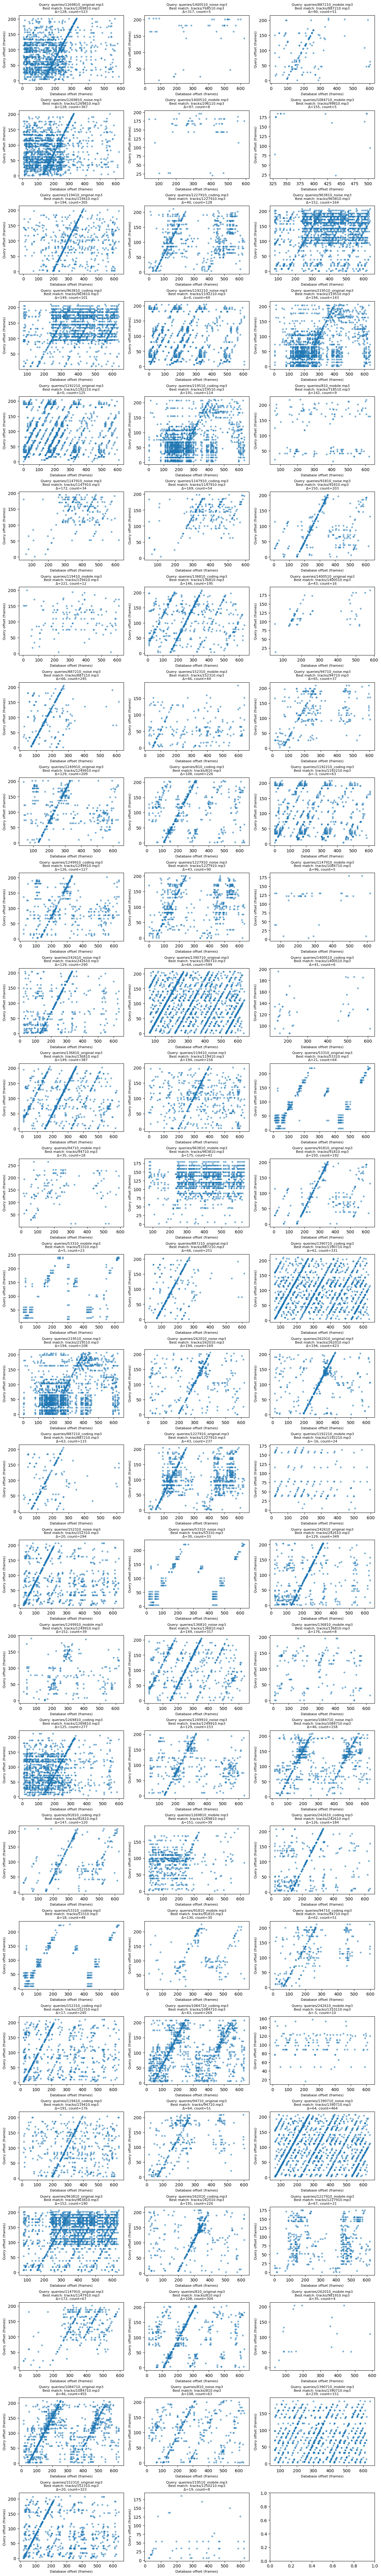

In [21]:
import math
import matplotlib.pyplot as plt

num_queries = len(cmaps_Q)
ncols = 3
nrows = math.ceil(num_queries / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), gridspec_kw={'hspace': 0.4} )
# If there's only one row, axes might be 1D. We can handle that by flattening.
axes = axes.flatten() if nrows > 1 or ncols > 1 else [axes]



# We will keep track of each query’s best match, offset, count, and correctness
results = []
num_correct = 0

plot_index = 0


for query_name, cmap in cmaps_Q.items():
    point_list = sorted(np.argwhere(cmap).tolist(), key=lambda x: x[1])


    matches = defaultdict(lambda: defaultdict(int))
    
    for anchor in point_list:
        target_points = get_target_zone_points(anchor, point_list, time_min_offset=5, time_max_offset=30, freq_min_offset=-15, freq_max_offset=15)

        for target_point in target_points:
            h = compute_hash(anchor, target_point)
            if h in database:
                database_matches = database[h]

                for track_name, track_offset in database_matches:
                    delta_offset = track_offset - anchor[1]

                    matches[track_name][delta_offset] += 1


    # Find the best match (track_name, delta_offset) with the highest count
    best_track = None
    best_delta = None
    best_count = 0
    
    for track_name, offset_counts in matches.items():
        for delta_offset, count in offset_counts.items():
            if count > best_count:
                best_count = count
                best_track = track_name
                best_delta = delta_offset

    # Check if match is correct
    query_id = extract_numeric_id(query_name)
    track_id = extract_numeric_id(best_track) if best_track else None
    correct = (query_id == track_id)
    
    # Store results
    results.append(
        (query_name, best_track, best_delta, best_count, correct)
    )
    
    # Increment correctness counter
    if correct:
        num_correct += 1


    # ******************************************************************************************************** #
    # ***************************** SHOWCASE SCATTERPLOT OF A MATCH (eg. diagnoal line) *************************** #
    # NOW WE COLLECT THE OFFSETS FOR PLOTTING
    db_offsets = []
    query_offsets = []
    if best_track is not None:
        for anchor in point_list:  # anchor[1] = query offset
            target_points = get_target_zone_points(anchor, point_list, time_min_offset=5, time_max_offset=30, freq_min_offset=-15, freq_max_offset=15)
            for target_point in target_points:
                h = compute_hash(anchor, target_point)
                if h in database:
                    for (track_name, track_offset) in database[h]:
                        if track_name == best_track:
                            db_offsets.append(track_offset)
                            query_offsets.append(anchor[1])

    # PLOT on the subplot
    ax = axes[plot_index]
    ax.scatter(db_offsets, query_offsets, alpha=0.5, s=10)
    ax.set_xlabel("Database offset (frames)", fontsize=8)
    ax.set_ylabel("Query offset (frames)", fontsize=8)
    ax.set_title(f"Query: {query_name}\nBest match: {best_track}\nΔ={best_delta}, count={best_count}", fontsize=8)
    
    plot_index += 1
    if plot_index >= len(axes):
        break  # in case there are more queries than subplot slots
# ******************************************************************************************************** #
# ******************************************************************************************************** #

# --------------------------------------------------------------------------
# (3) Print final results
# --------------------------------------------------------------------------
total_queries = len(cmaps_Q)
accuracy = num_correct / total_queries if total_queries else 0

print("\nMATCHING RESULTS:")
for row in results:
    qname, tname, offset, count, is_correct = row
    print(f"Query: {qname} => Best match: {tname}, Offset: {offset}, Count: {count}, Correct: {is_correct}")

print(f"\nCorrect matches: {num_correct}/{total_queries}")
print(f"Accuracy: {accuracy*100:.2f}%")
    
    


# Task 2

# Task 3

# Task 4